In [1]:
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import random

# from data.data_accessors import tmprss2_to_pandas
import numpy as np
from rdkit import Chem, DataStructs
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats

from sklearn.svm import LinearSVC
from sklearn.svm import LinearSVR
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV, cross_val_score

import pickle

random.seed(2)




Here, we import our TMPRSS2 QSAR Dataset, Dark Chemical Matter Dataset, and Screening Library 

In [2]:
# collect dataset
assays = pd.read_pickle('../processed_data/combined_dataset.pkl')
assays = assays[assays.activity_target.isin(['Active', 'Inactive'])]  # get rid of any 'Inconclusive'

dcm = pd.read_pickle('../processed_data/DarkChemicalMatter_processed.pkl.gz')

# testing data:
screening_data = pd.read_pickle('../processed_data/screening_data_processed.pkl')

In [3]:
screening_data

,source,name,morgan_fingerprint
0,drugbank,Bivalirudin,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,drugbank,Leuprolide,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,drugbank,Goserelin,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,drugbank,Gramicidin D,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,drugbank,Desmopressin,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
...,...,...,...
21019,broad,zotepine,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ..."
21020,broad,zoxazolamine,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
21021,broad,zoxazolamine,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
21022,broad,ZSTK-474,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


Here, we combine our assay data and dark chemical matter data. We next  80%/20% train/test split. This data is split into a training set (80%) and a testing/validation set (20%)

In [4]:
X_assays = np.stack(assays.morgan_fingerprint)
y_assays = np.ones(len(X_assays))

X_dcm = np.stack(dcm.morgan_fingerprint)
y_dcm = np.zeros(len(X_dcm))

X_combined = np.append(X_assays, X_dcm, axis = 0)
y_combined = np.append(y_assays, y_dcm)

X_train, X_test, y_train, y_test = train_test_split(X_combined, y_combined, test_size=0.2)

Here we use SKLearn GridSearch CV function to identify optimal C parameter for our preliminary SVM Classifier (trained on training set only)

In [5]:
Cs = np.logspace(-6, 2, 16)
clf = GridSearchCV(estimator=LinearSVC(random_state=0, tol=1e-5, max_iter = 10000, dual = False), param_grid=dict(C=Cs), n_jobs=-1)
clf.fit(X_train, y_train) 
c_param_SVC_train = clf.best_estimator_.C

In [6]:
c_param_SVC_train 

0.7356422544596406

Using the C parameter calculated above, we determine the Total Accuracy, False Positive Rate, False Negative Rate of our SVM Classifier

In [7]:
SVM_validation = make_pipeline(StandardScaler(), LinearSVC(random_state=0, tol=1e-5, C=c_param_SVC_train, max_iter = 10000, dual = False)) 
SVM_validation.fit(X_train, y_train)

pred = SVM_validation.predict(X_test)
accuracy = np.sum(pred == y_test)/y_test.size
accuracy

0.9996791100652476

In [8]:
i = 0
false_positive = 0
total_positive = 0
false_negative = 0
total_negative = 0
while(i < len(pred)):
    if(y_test[i] == 0):
        total_negative += 1
        if(pred[i] == 1):
            false_positive += 1
    elif(y_test[i] == 1):
        total_positive += 1
        if(pred[i] == 0):
            false_negative += 1 
    i = i + 1

false_positive/total_positive

0.005235602094240838

In [9]:
false_negative/total_negative

0.0002871912693854107

Here, we use SKLearn GridSearch CV function to identify optimal C parameter for our full SVM Classifier (trained on training set and testing set)

In [10]:
Cs = np.logspace(-6, 2, 16)
clf = GridSearchCV(estimator=LinearSVC(random_state=0, tol=1e-5, max_iter = 10000, dual = False), param_grid=dict(C=Cs), n_jobs=-1)
clf.fit(X_combined, y_combined) 
c_param_SVC_test = clf.best_estimator_.C

In [11]:
c_param_SVC_test

100.0

Here, we use our full SVM Classifier to identify potentially-active compounds from our screening library 

In [12]:
SVM_testing = make_pipeline(StandardScaler(), LinearSVC(random_state=0, tol=1e-5, C=c_param_SVC_test, max_iter = 10000, dual = False))
SVM_testing.fit(X_combined, y_combined)

screening_compounds = np.stack(screening_data.morgan_fingerprint)

pred = SVM_testing.predict(screening_compounds)
screening_data['predictions'] = pred
inactiveCompounds = screening_data[(screening_data['predictions'] == 0)].index
active_screening_compounds = screening_data.drop(inactiveCompounds)

In [13]:
len(active_screening_compounds)

510

In [14]:
#split training and testing data for each dataset, fill nan with acvalue_target
#y_assays_logKi = np.log10(assays.acvalue_scaled_to_tmprss2.fillna(assays.acvalue_target))

#train_X, test_X, train_y, test_y = train_test_split(X_assays, y_assays_logKi, test_size=0.2)

Next, we identify the subset of the training data for which Ki values can be scaled to TMPRSS2 for use in regression analysis. This data is split into a training set (80%) and a testing/validation set (20%)

In [15]:
y_assays_logKi_raw = np.log10(assays.acvalue_scaled_to_tmprss2)
nan_array = np.isnan(y_assays_logKi_raw)
not_nan = ~nan_array
y_assays_logKi = y_assays_logKi_raw[not_nan]
X_assays = X_assays[not_nan]

train_X, test_X, train_y, test_y = train_test_split(X_assays, y_assays_logKi, test_size=0.2)

Next, we use SKLearn GridSearch CV function to identify optimal C parameter for our preliminary Support Vector Regressor (trained on training set only)

In [16]:
# Use SKLearn GridSearch CV function to identify optimal C parameter for SVM regression (training set)
Cs = np.logspace(-6, 2, 16)
clf = GridSearchCV(estimator=LinearSVR(random_state=0, tol=1e-5, max_iter = 10000, dual = True), param_grid=dict(C=Cs), n_jobs=-1)
clf.fit(train_X, train_y) 
c_param_SVR_test = clf.best_estimator_.C


In [17]:
c_param_SVR_test

0.018478497974222907

Using the C paramater calculated above, we calculate the RMSE of our regressor and the correlation coefficient between our predicted and ground-truth values.

SVR RMSE:0.772626964424397
(0.7811294078353609, 1.1662805017673853e-18)


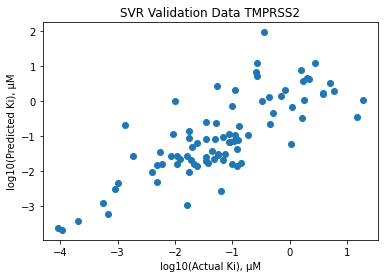

In [18]:
#Run SVM regression using SKLearn on test set. Linear regression for prediction accuracy
svmReg = make_pipeline(StandardScaler(), LinearSVR(random_state=0, tol=1e-5, C=c_param_SVR_test, max_iter = 10000, dual = True))
svmReg.fit(train_X, train_y)

pred = svmReg.predict(test_X)
MSE = mean_squared_error(test_y, pred)
RMSE = np.sqrt(MSE)
print("SVR RMSE:{}".format(RMSE))

plt.scatter(test_y, pred)
plt.xlabel('log10(Actual Ki), μM')
plt.ylabel('log10(Predicted Ki), μM')
plt.title('SVR Validation Data TMPRSS2')

corr = scipy.stats.pearsonr(test_y, pred)
print(corr)

Next, we use SKLearn GridSearch CV function to identify optimal C parameter for our full Support Vector Regressor (trained on training set and testing set)

In [19]:
#SKLearn C parameter optimization
Cs = np.logspace(-6, 2, 16)
clf_full = GridSearchCV(estimator=LinearSVR(random_state=0, tol=1e-5, max_iter = 10000, dual = True), param_grid=dict(C=Cs), n_jobs=-1)
clf_full.fit(X_assays, y_assays_logKi) 
c_param_full = clf_full.best_estimator_.C


In [20]:
c_param_full 

0.018478497974222907

Finally, using this C parameter, we screen the active compounds identified by our SVM Classifier to identify the compounds which are predicted to bind most effectively to TMPRSS2

In [21]:
#Run regressor (trained on full dataset)
test_compounds = np.stack(active_screening_compounds.morgan_fingerprint)

svmReg_full = make_pipeline(StandardScaler(), LinearSVR(random_state=0, tol=1e-5, C=c_param_full, max_iter = 10000, dual = True))
svmReg_full.fit(X_assays, y_assays_logKi)
pred_values = svmReg_full.predict(test_compounds)

In [22]:
#identify top hits
active_screening_compounds['pred_value_TMPRSS2'] = pred_values
active_screening_compounds.sort_values(by='pred_value_TMPRSS2').head(20)

,source,name,morgan_fingerprint,predictions,pred_value_TMPRSS2
10797,reframe,Nafamostat,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, ...",1.0,-4.573876
19603,broad,substance-p,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, ...",1.0,-3.270127
10749,reframe,Camostat,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, ...",1.0,-3.063754
4725,drugbank,"Sar9, Met (O2)11-Substance P","[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1.0,-2.878925
10877,broad,"[sar9,met(o2)11]-substance-p","[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1.0,-2.878925
10789,reframe,RWJ-58643,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1.0,-2.231467
10747,reframe,Sepimostat mesilate,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1.0,-2.119771
2513,drugbank,RWJ-56423,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1.0,-2.051523
19919,broad,telaprevir,"[0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ...",1.0,-2.013405
4645,drugbank,Telaprevir,"[0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ...",1.0,-2.013405


Text(0.5, 1.0, 'Predicted Ki Values of Potentially-Active TMPRSS2 Inhibitors')

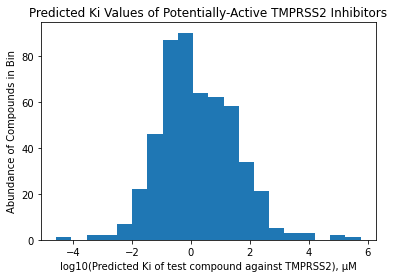

In [23]:
plt.hist(active_screening_compounds.pred_value_TMPRSS2, bins = 20)
plt.xlabel('log10(Predicted Ki of test compound against TMPRSS2), μM')
plt.ylabel('Abundance of Compounds in Bin')
plt.title('Predicted Ki Values of Potentially-Active TMPRSS2 Inhibitors')

Now, we repeat the same SVM Regression procedure using molecules tested against KLKB1

In [40]:
assays_KLKB1 = assays.loc[assays['target'] == 'KLKB1']
y_assays_logKi_raw_KLKB1 = np.log10(assays_KLKB1.acvalue_target)
nan_array = np.isnan(y_assays_logKi_raw_KLKB1)
not_nan = ~nan_array
y_assays_logKi_KLKB1 = y_assays_logKi_raw_KLKB1[not_nan]
X_assays_KLKB1 = np.stack(assays_KLKB1[not_nan].morgan_fingerprint)

train_X, test_X, train_y, test_y = train_test_split(X_assays_KLKB1, y_assays_logKi_KLKB1, test_size=0.2)

In [41]:
# Use SKLearn GridSearch CV function to identify optimal C parameter for SVM regression (training set)
Cs = np.logspace(-6, 2, 16)
clf = GridSearchCV(estimator=LinearSVR(random_state=0, tol=1e-5, max_iter = 10000, dual = True), param_grid=dict(C=Cs), n_jobs=-1)
clf.fit(train_X, train_y) 
c_param_SVR_test_KLKB1 = clf.best_estimator_.C

In [42]:
c_param_SVR_test_KLKB1

0.0630957344480193

SVR RMSE:0.9141043462758751
(0.8151057716214991, 7.410156879758979e-22)


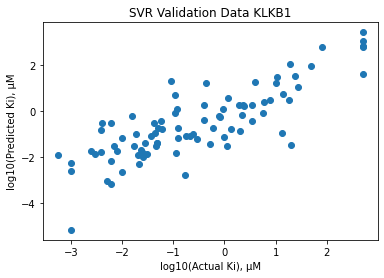

In [43]:
#Run SVM regression using SKLearn on test set. Linear regression for prediction accuracy
svmReg = make_pipeline(StandardScaler(), LinearSVR(random_state=0, tol=1e-5, C=c_param_SVR_test_KLKB1, max_iter = 10000, dual = True))
svmReg.fit(train_X, train_y)

pred = svmReg.predict(test_X)
MSE = mean_squared_error(test_y, pred)
RMSE = np.sqrt(MSE)
print("SVR RMSE:{}".format(RMSE))

plt.scatter(test_y, pred)
plt.xlabel('log10(Actual Ki), μM')
plt.ylabel('log10(Predicted Ki), μM')
plt.title('SVR Validation Data KLKB1')

corr = scipy.stats.pearsonr(test_y, pred)
print(corr)

In [44]:
#SKLearn C parameter optimization
Cs = np.logspace(-6, 2, 16)
clf_full = GridSearchCV(estimator=LinearSVR(random_state=0, tol=1e-5, max_iter = 10000, dual = True), param_grid=dict(C=Cs), n_jobs=-1)
clf_full.fit(X_assays_KLKB1, y_assays_logKi_KLKB1) 
c_param_full_KLKB1 = clf_full.best_estimator_.C

In [45]:
c_param_full_KLKB1

0.0630957344480193

In [46]:
#Run regressor (trained on full dataset)
test_compounds = np.stack(active_screening_compounds.morgan_fingerprint)

svmReg_full_KLKB1 = make_pipeline(StandardScaler(), LinearSVR(random_state=0, tol=1e-5, C=c_param_full_KLKB1, max_iter = 10000, dual = True))
svmReg_full_KLKB1.fit(X_assays_KLKB1, y_assays_logKi_KLKB1)
pred_values_KLKB1 = svmReg_full_KLKB1.predict(test_compounds)

#identify top hits
active_screening_compounds['pred_value_KLKB1'] = pred_values_KLKB1
active_screening_compounds.sort_values(by='pred_value_KLKB1').head(20)

,source,name,morgan_fingerprint,predictions,pred_value_TMPRSS2,pred_value_KLKB1
10316,drugbank,Cobomarsen,"[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1.0,4.750049,-4.390812
9100,drugbank,JTK-853,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1.0,-0.042649,-3.397719
13925,broad,diflorasone-diacetate,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1.0,1.373709,-3.016103
4269,drugbank,TRANS-4-(GUANIDINOMETHYL)-CYCLOHEXANE-L-YL-D-3...,"[0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1.0,-0.582598,-2.780173
10813,reframe,BMS-654457,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1.0,-0.932098,-2.698966
6471,drugbank,2-(2-METHYLPHENYL)-1H-INDOLE-5-CARBOXIMIDAMIDE,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1.0,0.359217,-2.635103
1841,drugbank,CRA_17312,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1.0,-0.844427,-2.628200
6143,drugbank,5-Chloro-N-{(3S)-1-[(2S)-1-(4-morpholinyl)-1-o...,"[0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, ...",1.0,-1.014221,-2.317736
15774,broad,itacitinib,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1.0,2.987064,-2.254464
8335,drugbank,Itacitinib,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1.0,2.987064,-2.254464


Text(0.5, 1.0, 'Predicted Ki Values of Potentially-Active KLKB1 Inhibitors')

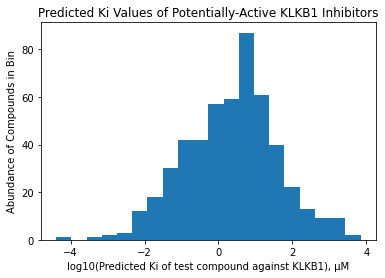

In [47]:
plt.hist(active_screening_compounds.pred_value_KLKB1, bins = 20)
plt.xlabel('log10(Predicted Ki of test compound against KLKB1), μM')
plt.ylabel('Abundance of Compounds in Bin')
plt.title('Predicted Ki Values of Potentially-Active KLKB1 Inhibitors')

Finally, we save raw results, as well as our results with duplicates removed

In [36]:
active_screening_compounds_sorted = active_screening_compounds.sort_values(by='pred_value_TMPRSS2')
active_screening_compounds_sorted.to_csv('svm_sreening_results_raw.csv')

In [37]:
active_screening_compounds_sorted["name"].str.lower()
active_screening_compounds_sorted.drop_duplicates(subset=['name'], keep='first')
active_screening_compounds_sorted.to_csv('svm_screening_results_no_duplicate_names.csv')

In [38]:
active_fingerprints = np.stack(active_screening_compounds_sorted.morgan_fingerprint)
unique, indices = np.unique(active_fingerprints, axis = 0, return_index=True)
active_screening_compounds_sorted = active_screening_compounds_sorted.iloc[indices, :]

In [39]:
active_screening_compounds_sorted = active_screening_compounds_sorted.sort_values(by='pred_value_TMPRSS2')
active_screening_compounds_sorted
active_screening_compounds_sorted.to_csv('svm_screening_results_no_duplicate_namess_or_fingerprints.csv')